In [1]:
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models

import pytorch_lightning as pl

from transforms.transform import base_transform, augmented_transform, IdentityTransform

from models.encoders import get_resnet18_encoder, get_shufflenetv2_encoder, get_alexnet_encoder, SpectrumCNN

from models.lit_models import CNN_classifier

batch_size = 64

# 1. AMP PHASE DATASET

In [3]:
train_dataset_amp_phase = torchvision.datasets.ImageFolder('data/images_amp_phase/train', transform=augmented_transform)
test_dataset_amp_phase = torchvision.datasets.ImageFolder('data/images_amp_phase/test', transform=base_transform)

In [4]:
train_dataloader = DataLoader(train_dataset_amp_phase, shuffle=True, batch_size=batch_size, num_workers=1)
val_dataloader = DataLoader(train_dataset_amp_phase, shuffle=False, batch_size=batch_size, num_workers=1)

In [6]:
encoder = get_shufflenetv2_encoder()

# encoder = models.resnet18(num_classes=512)

lit_model = CNN_classifier(encoder=encoder)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr:  80%|████████  | 80/100 [00:09<00:02,  8.78it/s]
LR finder stopped early after 80 steps due to diverging

{'epoch_avg_train_loss': 4.603492769598961}


/tmp/ipykernel_35772/39222409.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.00017378008287493763


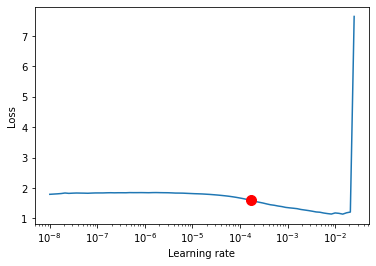

In [7]:
trainer = pl.Trainer(
    auto_lr_find=True,
    gpus=1, max_epochs=30,
    enable_checkpointing=True,
    log_every_n_steps=10,
    amp_backend="native",
    num_sanity_val_steps=0
)
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(lit_model, train_dataloaders=train_dataloader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
print(lr_finder.suggestion())

In [8]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
lit_model.hparams.lr = new_lr

# Fit model
trainer.fit(lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | encoder   | ShuffleNetV2      | 1.8 M 
1 | fc        | Sequential        | 263 K 
2 | criterion | BCEWithLogitsLoss | 0     
3 | resizer   | Resize            | 0     
------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.166     Total estimated model params size (MB)
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: 

Epoch 29: 100%|██████████| 1022/1022 [01:14<00:00, 13.72it/s, loss=0.0425, v_num=2]


# 2. SPECTROGRAM DATASET

In [2]:
train_dataset_spectrogram = torchvision.datasets.ImageFolder('data/images_amp_phase/train', transform=augmented_transform)
test_dataset_spectrogram = torchvision.datasets.ImageFolder('data/images_amp_phase/test', transform=base_transform)

In [3]:
train_dataloader = DataLoader(train_dataset_spectrogram, shuffle=True, batch_size=batch_size, num_workers=1)
val_dataloader = DataLoader(test_dataset_spectrogram, shuffle=False, batch_size=batch_size, num_workers=1)

In [5]:
encoder = get_alexnet_encoder()

# encoder = models.resnet18(num_classes=512)

lit_model = CNN_classifier(encoder=encoder)

### prepare trainer

trainer = pl.Trainer(
    auto_lr_find=True,
    gpus=1, max_epochs=30,
    enable_checkpointing=True,
    log_every_n_steps=10,
    amp_backend="native",
    num_sanity_val_steps=0
)
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(lit_model, train_dataloaders=train_dataloader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
print(lr_finder.suggestion())

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
lit_model.hparams.lr = new_lr

# Fit model
trainer.fit(lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shstan/anaconda3/envs/pytorch_base/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Finding best initial lr:  29%|██▉       | 29/100 [00:02<00:05, 12.15it/s]

In [9]:
from torchsummary import summary
summary(SpectrumCNN(), (3, 64, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 54, 54]          17,472
              ReLU-2           [-1, 48, 54, 54]               0
         MaxPool2d-3           [-1, 48, 27, 27]               0
            Conv2d-4          [-1, 128, 23, 23]         153,728
              ReLU-5          [-1, 128, 23, 23]               0
         MaxPool2d-6          [-1, 128, 11, 11]               0
            Conv2d-7            [-1, 192, 9, 9]         221,376
              ReLU-8            [-1, 192, 9, 9]               0
            Conv2d-9            [-1, 192, 7, 7]         331,968
             ReLU-10            [-1, 192, 7, 7]               0
           Conv2d-11            [-1, 128, 5, 5]         221,312
             ReLU-12            [-1, 128, 5, 5]               0
          Flatten-13                 [-1, 3200]               0
           Linear-14                 [-